<a href="https://colab.research.google.com/github/bu11ymaguire/studying/blob/main/ReinforcementLearning/GridWorld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


class Renderer:
    def __init__(self, reward_map, goal_state, wall_state):
        self.reward_map = reward_map
        self.goal_state = goal_state
        self.wall_state = wall_state
        self.ys = len(self.reward_map)
        self.xs = len(self.reward_map[0])

        self.ax = None
        self.fig = None
        self.first_flg = True

    def set_figure(self, figsize=None):
        fig = plt.figure(figsize=figsize)
        self.ax = fig.add_subplot(111)
        ax = self.ax
        ax.clear()
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax.set_xticks(range(self.xs))
        ax.set_yticks(range(self.ys))
        ax.set_xlim(0, self.xs)
        ax.set_ylim(0, self.ys)
        ax.grid(True)

    def render_v(self, v=None, policy=None, print_value=True):
        self.set_figure()

        ys, xs = self.ys, self.xs
        ax = self.ax

        if v is not None:
            color_list = ['red', 'white', 'green']
            cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
                'colormap_name', color_list)

            # dict -> ndarray
            v_dict = v
            v = np.zeros(self.reward_map.shape)
            for state, value in v_dict.items():
                v[state] = value

            vmax, vmin = v.max(), v.min()
            vmax = max(vmax, abs(vmin))
            vmin = -1 * vmax
            vmax = 1 if vmax < 1 else vmax
            vmin = -1 if vmin > -1 else vmin

            ax.pcolormesh(np.flipud(v), cmap=cmap, vmin=vmin, vmax=vmax)

        for y in range(ys):
            for x in range(xs):
                state = (y, x)
                r = self.reward_map[y, x]
                if r != 0 and r is not None:
                    txt = 'R ' + str(r)
                    if state == self.goal_state:
                        txt = txt + ' (GOAL)'
                    ax.text(x+.1, ys-y-0.9, txt)

                if (v is not None) and state != self.wall_state:
                    if print_value:
                        offsets = [(0.4, -0.15), (-0.15, -0.3)]
                        key = 0
                        if v.shape[0] > 7: key = 1
                        offset = offsets[key]
                        ax.text(x+offset[0], ys-y+offset[1], "{:12.2f}".format(v[y, x]))

                if policy is not None and state != self.wall_state:
                    actions = policy[state]
                    max_actions = [kv[0] for kv in actions.items() if kv[1] == max(actions.values())]

                    arrows = ["↑", "↓", "←", "→"]
                    offsets = [(0, 0.1), (0, -0.1), (-0.1, 0), (0.1, 0)]
                    for action in max_actions:
                        arrow = arrows[action]
                        offset = offsets[action]
                        if state == self.goal_state:
                            continue
                        ax.text(x+0.45+offset[0], ys-y-0.5+offset[1], arrow)

                if state == self.wall_state:
                    ax.add_patch(plt.Rectangle((x,ys-y-1), 1, 1, fc=(0.4, 0.4, 0.4, 1.)))
        plt.show()

    def render_q(self, q, show_greedy_policy=True):
        self.set_figure()

        ys, xs = self.ys, self.xs
        ax = self.ax
        action_space = [0, 1, 2, 3]

        qmax, qmin = max(q.values()), min(q.values())
        qmax = max(qmax, abs(qmin))
        qmin = -1 * qmax
        qmax = 1 if qmax < 1 else qmax
        qmin = -1 if qmin > -1 else qmin


        color_list = ['red', 'white', 'green']
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
            'colormap_name', color_list)

        for y in range(ys):
            for x in range(xs):
                for action in action_space:
                    state = (y, x)
                    r = self.reward_map[y, x]
                    if r != 0 and r is not None:
                        txt = 'R ' + str(r)
                        if state == self.goal_state:
                            txt = txt + ' (GOAL)'
                        ax.text(x+.05, ys-y-0.95, txt)

                    if state == self.goal_state:
                        continue

                    tx, ty = x, ys-y-1

                    action_map = {
                        0: ((0.5+tx, 0.5+ty), (tx+1, ty+1), (tx, ty+1)),
                        1: ((tx, ty), (tx+1, ty), (tx+0.5, ty+0.5)),
                        2: ((tx, ty), (tx+0.5, ty+0.5), (tx, ty+1)),
                        3: ((0.5+tx, 0.5+ty), (tx+1, ty), (tx+1, ty+1)),
                    }
                    offset_map = {
                        0: (0.1, 0.8),
                        1: (0.1, 0.1),
                        2: (-0.2, 0.4),
                        3: (0.4, 0.4),
                    }
                    if state == self.wall_state:
                        ax.add_patch(plt.Rectangle((tx, ty), 1, 1, fc=(0.4, 0.4, 0.4, 1.)))
                    elif state in self.goal_state:
                        ax.add_patch(plt.Rectangle((tx, ty), 1, 1, fc=(0., 1., 0., 1.)))
                    else:

                        tq = q[(state, action)]
                        color_scale = 0.5 + (tq / qmax) / 2  # normalize: 0.0-1.0

                        poly = plt.Polygon(action_map[action],fc=cmap(color_scale))
                        ax.add_patch(poly)

                        offset= offset_map[action]
                        ax.text(tx+offset[0], ty+offset[1], "{:12.2f}".format(tq))
        plt.show()

        if show_greedy_policy:
            policy = {}
            for y in range(self.ys):
                for x in range(self.xs):
                    state = (y, x)
                    qs = [q[state, action] for action in range(4)]  # action_size
                    max_action = np.argmax(qs)
                    probs = {0:0.0, 1:0.0, 2:0.0, 3:0.0}
                    probs[max_action] = 1
                    policy[state] = probs
            self.render_v(None, policy)

In [40]:
# Monkey-patching the render_v method to fix NameError
import types
def fixed_render_v(self, v=None, policy=None, print_value=True):
    # This version directly calls Renderer instead of gridworld_render.Renderer
    renderer = Renderer(self.reward_map, self.goal_state,
                                      self.wall_state)
    renderer.render_v(v, policy, print_value)

#GridWorld

In [41]:
import numpy as np

class GridWorld:
  def __init__(self):
    self.action_space = [0,1,2,3]
    self.action_meaning = {
        0: "UP",
        1: "DOWN",
        2: "LEFT",
        3: "RIGHT"
    }

    self.reward_map = np.array(
        [[0,0,0,1.0],
         [0,None,0,-1.0],
            [0,0,0,0]
        ]
    )

    self.goal_state = (0,3) #목표 지점
    self.wall_state = (1,1) #벽
    self.start_state = (2,0) #시작 지점
    self.agent_state = self.start_state

  @property
  def height(self):
    return len(self.reward_map)

  @property
  def width(self):
    return len(self.reward_map[0])

  @property
  def shape(self):
    return self.reward_map.shape

  def actions(self):
    return self.action_space

  def states(self):
    for h in range(self.height):
      for w in range(self.width):
        yield(h,w)

  def next_state(self, state, action):
    action_move_map = [(-1,0),(1,0),(0,1),(0,-1)]
    move = action_move_map[action]
    next_state = (state[0]+ move[0],state[1] + move[1])
    ny, nx = next_state

    if nx < 0 or nx >= self.width or ny < 0 or ny >= self.height: #이동하게 될 위치가 영역의 밖인 경우?
      next_state = state
    elif next_state == self.wall_state: #이동하게 될 위치가 벽인 경우
      next_state = state

    return next_state

  def reward(self, state, action, next_state):
    return self.reward_map[next_state]

  def render_v(self, v=None, policy=None, print_value=True):
        renderer = gridworld_render.Renderer(self.reward_map, self.goal_state,
                                          self.wall_state)
        renderer.render_v(v, policy, print_value)

In [ ]:
env = GridWorld()

for _ in env.actions():
  print(_)

print('===')

for state in env.states():
  print(state)

0
1
2
3
===
(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(2, 0)
(2, 1)
(2, 2)
(2, 3)


In [ ]:
env = GridWorld()
V = {}

for state in env.states():
  V[state] = 0

state = (1,2)
print(V[state])

0


## 가치 함수의 모든 딕셔너리 초기화 by Using defaultdict

In [ ]:
from collections import defaultdict

env = GridWorld()
V = defaultdict(lambda : 0)

state = (1,2)
print(V[state])

0


## 무작위 정책 구현

In [ ]:
pi = defaultdict(lambda :{0:0.25,1:0.25,2:0.25,3:0.25})

state = (0,1)
print(pi[state])

{0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}


## 반복적 정책 평가

In [ ]:
def eval_onestep(pi, V, env, gamma = 0.9):
  for state in env.states(): # 각 상태에서 접근
    if state == env.goal_state: # 목표 상태에서의 가치 함수는 항상 0
      V[state] = 0
      continue

    actions_probs = pi[state]
    new_V = 0

    #각 행동에 접근
    for action, action_prob in actions_probs.items():
        next_state = env.next_state(state, action)
        r = env.reward(state, action, next_state)
        new_V += action_prob * (r + gamma * V[next_state])

    V[state] = new_V
  return V

## 반복 갱신 처리 함수

In [ ]:
def policy_eval(pi, V, env, gamma, threshold = 0.001):
  while(True):
    old_v = V.copy()
    V = eval_onestep(pi, V, env, gamma)

    delta = 0
    for state in V.keys():
      t = abs(V[state] - old_v[state])
      if delta < t:
          delta = t

    if delta < threshold:
        break

  return V

## 반복 정책 수행

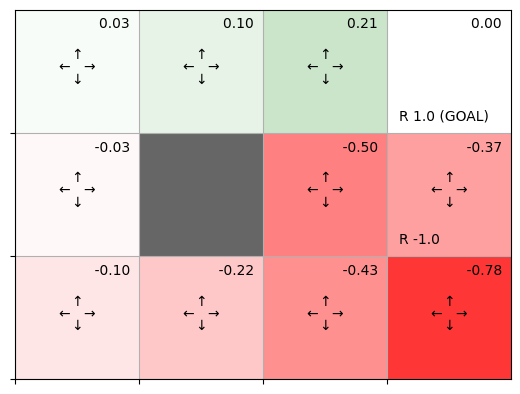

In [42]:
env = GridWorld()
gamma = 0.9

pi = defaultdict(lambda :{0:0.25,1:0.25,2:0.25,3:0.25})
V = defaultdict(lambda : 0)

env.render_v = types.MethodType(fixed_render_v, env)

V = policy_eval(pi, V, env, gamma)
env.render_v(V, pi)